In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, CallbackList
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import os

print("Imports successful!")

✅ Imports successful!


In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        meanings = env.unwrapped.get_action_meanings()
        self.fire_action = meanings.index("FIRE") if "FIRE" in meanings else None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self.fire_action is None:
            return obs, info
        
        obs, reward, terminated, truncated, info = self.env.step(self.fire_action)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
        return obs, info

def make_env(render_mode=None):
    def _env():
        env = gym.make("ALE/Breakout-v5", render_mode=render_mode, frameskip=1)
        env = FireResetEnv(env)
        env = AtariPreprocessing(
            env,
            grayscale_obs=True,
            frame_skip=4,
            scale_obs=False,
            terminal_on_life_loss=False  # ← CRITICAL FIX
        )
        env = FrameStack(env, num_stack=4)
        return env
    return _env


✅ Environment setup complete!


In [ ]:
# Create environment
env = DummyVecEnv([make_env()])

# Training parameters
TOTAL_TIMESTEPS = 2_000_000

print("Environment created!")
print(f"Training will run for {TOTAL_TIMESTEPS:,} timesteps")

✅ Environment created!
Training will run for 2,000,000 timesteps


In [43]:
# Check for existing checkpoint
checkpoint_dir = "./checkpoints/"
checkpoint_info = None

if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.zip')]
    if checkpoints:
        steps = [int(f.split('_')[-2]) for f in checkpoints]
        latest_idx = steps.index(max(steps))
        checkpoint_path = os.path.join(checkpoint_dir, checkpoints[latest_idx])
        completed_steps = max(steps)
        checkpoint_info = (checkpoint_path, completed_steps)
        print(f"Found checkpoint: {checkpoint_path}")
        print(f"Completed steps: {completed_steps:,}")
    else:
        print("No checkpoints found - will start fresh")
else:
    print("No checkpoint directory - will start fresh")

No checkpoint directory - will start fresh


In [ ]:
if checkpoint_info:
    checkpoint_path, completed_steps = checkpoint_info
    print(f"Resuming from: {checkpoint_path}")
    model = DQN.load(checkpoint_path, env=env)
    remaining_steps = TOTAL_TIMESTEPS - completed_steps
    print(f"Remaining steps: {remaining_steps:,}")
else:
    print("Creating new model")
    model = DQN(
        "CnnPolicy",
        env,
        learning_rate=1e-4,
        buffer_size=100_000,
        learning_starts=50_000,      # More exploration
        batch_size=32,
        gamma=0.99,
        train_freq=4,
        target_update_interval=1_000,
        exploration_fraction=0.3,     # 30% of training
        exploration_initial_eps=1.0,
        exploration_final_eps=0.02,
        verbose=1
    )
    remaining_steps = TOTAL_TIMESTEPS

print("Model ready!")

🆕 Creating new model
Using cpu device
✅ Model ready!


c:\Users\mirza\OneDrive\Documents\FinalProject1\env\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 2.43GB
  warnings.warn(


In [45]:
# Checkpoint callback - saves every 100k steps
checkpoint_callback = CheckpointCallback(
    save_freq=100_000,
    save_path="./checkpoints/",
    name_prefix="dqn_breakout"
)

# Action monitoring callback - checks every 50k steps
action_callback = ActionDistributionCallback(check_freq=50_000)

# Combine callbacks
callbacks = CallbackList([checkpoint_callback, action_callback])

print("Callbacks configured!")
print("   - Checkpoint every 100,000 steps")
print("   - Action distribution check every 50,000 steps")

Callbacks configured!
   - Checkpoint every 100,000 steps
   - Action distribution check every 50,000 steps


In [46]:
print(f"Starting training for {remaining_steps:,} timesteps...")
print("="*60)
print("This will take several hours. Your laptop should not sleep!")
print("="*60)

model.learn(
    total_timesteps=remaining_steps,
    callback=callbacks,
    reset_num_timesteps=False
)

# Save final model
model.save("dqn_breakout_final")
print("\nTraining complete!")
print("Model saved as 'dqn_breakout_final.zip'")

Starting training for 2,000,000 timesteps...
This will take several hours. Your laptop should not sleep!
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 680      |
|    time_elapsed     | 0        |
|    total_timesteps  | 599      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 664      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1202     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 673      |
|    time_elapsed     | 3        |
|    total_timesteps

In [52]:
print("\n" + "="*60)
print("RUNNING DIAGNOSTICS")
print("="*60)

obs = env.reset()
actions = []
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=False)
    actions.append(action[0])
    obs, _, _, _ = env.step(action)

action_counts = np.bincount(actions, minlength=4)
print("\nAction distribution (1000 steps):")
for i, count in enumerate(action_counts):
    print(f"   Action {i}: {count:4d} ({count/10:.1f}%)")

if action_counts[0] > 900:
    print("\nWARNING: Agent stuck doing NOOP - needs retraining with terminal_on_life_loss=False!")
else:
    print("\nAction distribution looks good!")

print(f"\nCurrent epsilon: {model.exploration_rate:.4f}")


RUNNING DIAGNOSTICS

Action distribution (1000 steps):
   Action 0:  273 (27.3%)
   Action 1:   69 (6.9%)
   Action 2:  227 (22.7%)
   Action 3:  431 (43.1%)

Action distribution looks good!

Current epsilon: 0.0200


In [ ]:
print("\n" + "="*60)
print("EVALUATING MODEL - FIXED VERSION")
print("="*60)

def evaluate_fixed(model, episodes=10):
    rewards = []
    for ep in range(episodes):
        # Create environment WITHOUT DummyVecEnv
        eval_env = make_env()()
        obs, info = eval_env.reset()
        
        # Wrap observation for model (add batch dimension)
        obs = np.expand_dims(obs, axis=0)
        
        done = False
        total = 0
        steps = 0

        while not done and steps < 10000:
            action, _ = model.predict(obs, deterministic=True)
            
            # Step environment (unwrap action from array)
            obs_new, reward, terminated, truncated, info = eval_env.step(action[0])
            
            # Re-wrap for next prediction
            obs = np.expand_dims(obs_new, axis=0)
            
            total += reward
            steps += 1
            done = terminated or truncated

        eval_env.close()
        rewards.append(total)
        print(f"Episode {ep+1}: Reward = {total:.1f}, Steps = {steps}")

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(f"\nResults: {mean_reward:.2f} ± {std_reward:.2f}")
    
    if mean_reward == 0:
        print("Still zero reward - agent may not have learned successfully")
    elif mean_reward < 5:
        print("Low reward - agent learned basics but needs more training")
    else:
        print("Model is learning!")
    
    return rewards

scores = evaluate_fixed(model, episodes=10)


📈 EVALUATING MODEL - FIXED VERSION
Episode 1: Reward = 24.0, Steps = 10000
Episode 2: Reward = 11.0, Steps = 10000
Episode 3: Reward = 11.0, Steps = 10000
Episode 4: Reward = 12.0, Steps = 10000
Episode 5: Reward = 9.0, Steps = 10000
Episode 6: Reward = 19.0, Steps = 701
Episode 7: Reward = 14.0, Steps = 10000
Episode 8: Reward = 21.0, Steps = 739
Episode 9: Reward = 14.0, Steps = 10000
Episode 10: Reward = 33.0, Steps = 940

📊 Results: 16.80 ± 7.10
✅ Model is learning!


In [56]:
# Watch the agent play (this will open a window)
print("🎮 Playing one episode with visualization...")

# Create environment WITHOUT DummyVecEnv
test_env = make_env("human")()
obs, info = test_env.reset()

# Wrap observation for model
obs = np.expand_dims(obs, axis=0)

done = False
total_reward = 0
steps = 0

while not done and steps < 10000:
    action, _ = model.predict(obs, deterministic=True)
    
    # Step environment (unwrap action from array)
    obs_new, reward, terminated, truncated, info = test_env.step(action[0])
    
    # Re-wrap for next prediction
    obs = np.expand_dims(obs_new, axis=0)
    
    total_reward += reward
    steps += 1
    done = terminated or truncated

print(f"Episode finished: Reward = {total_reward}, Steps = {steps}")
test_env.close()

🎮 Playing one episode with visualization...
Episode finished: Reward = 15.0, Steps = 634


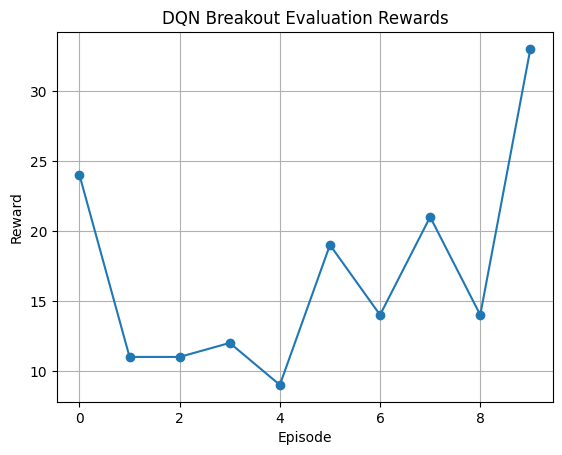

In [57]:
plt.plot(scores, marker="o")
plt.title("DQN Breakout Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()

In [ ]:
# Close environment
env.close()
print("Environment closed. Training session complete!")

✅ Environment closed. Training session complete!
